In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.cluster import DBSCAN

raw_path = "/Finance_data.csv"
df_raw = pd.read_csv(raw_path)
df = df_raw.copy()
df.head()

,gender,age,Investment_Avenues,Mutual_Funds,Equity_Market,Debentures,Government_Bonds,Fixed_Deposits,PPF,Gold,...,Duration,Invest_Monitor,Expect,Avenue,What are your savings objectives?,Reason_Equity,Reason_Mutual,Reason_Bonds,Reason_FD,Source
0,Female,34,Yes,1,2,5,3,7,6,4,...,1-3 years,Monthly,20%-30%,Mutual Fund,Retirement Plan,Capital Appreciation,Better Returns,Safe Investment,Fixed Returns,Newspapers and Magazines
1,Female,23,Yes,4,3,2,1,5,6,7,...,More than 5 years,Weekly,20%-30%,Mutual Fund,Health Care,Dividend,Better Returns,Safe Investment,High Interest Rates,Financial Consultants
2,Male,30,Yes,3,6,4,2,5,1,7,...,3-5 years,Daily,20%-30%,Equity,Retirement Plan,Capital Appreciation,Tax Benefits,Assured Returns,Fixed Returns,Television
3,Male,22,Yes,2,1,3,7,6,4,5,...,Less than 1 year,Daily,10%-20%,Equity,Retirement Plan,Dividend,Fund Diversification,Tax Incentives,High Interest Rates,Internet
4,Female,24,No,2,1,3,6,4,5,7,...,Less than 1 year,Daily,20%-30%,Equity,Retirement Plan,Capital Appreciation,Better Returns,Safe Investment,Risk Free,Internet


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 24 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   gender                             40 non-null     object
 1   age                                40 non-null     int64 
 2   Investment_Avenues                 40 non-null     object
 3   Mutual_Funds                       40 non-null     int64 
 4   Equity_Market                      40 non-null     int64 
 5   Debentures                         40 non-null     int64 
 6   Government_Bonds                   40 non-null     int64 
 7   Fixed_Deposits                     40 non-null     int64 
 8   PPF                                40 non-null     int64 
 9   Gold                               40 non-null     int64 
 10  Stock_Marktet                      40 non-null     object
 11  Factor                             40 non-null     object
 12  Objective 

In [ ]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
print("\n Colunas numéricas:", list(numeric_cols))


 Colunas numéricas: ['age', 'Mutual_Funds', 'Equity_Market', 'Debentures', 'Government_Bonds', 'Fixed_Deposits', 'PPF', 'Gold']


In [ ]:
#Detectar outliers
def detect_outliers_zscore(df, col, threshold=3):
    z = np.abs(stats.zscore(df[col]))
    return df[z > threshold]

outliers_z = {col: detect_outliers_zscore(df, col) for col in numeric_cols}

In [ ]:
#Detectar outliers
def detect_outliers_iqr(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    return df[(df[col] < lower) | (df[col] > upper)]

outliers_iqr = {col: detect_outliers_iqr(df, col) for col in numeric_cols}


## Detectar outliers com DBSCAN

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[numeric_cols])

db = DBSCAN(eps=2, min_samples=5)
labels = db.fit_predict(X_scaled)

df['DBSCAN_Cluster'] = labels
outliers_db = df[df['DBSCAN_Cluster'] == -1]
print(f"\nOutliers detectados via DBSCAN: {len(outliers_db)} registros")



Outliers detectados via DBSCAN: 12 registros


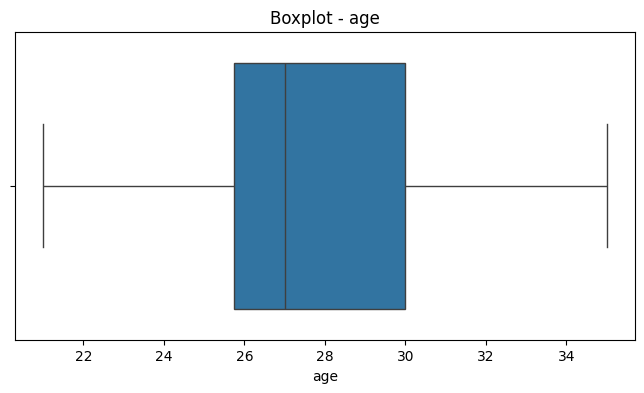

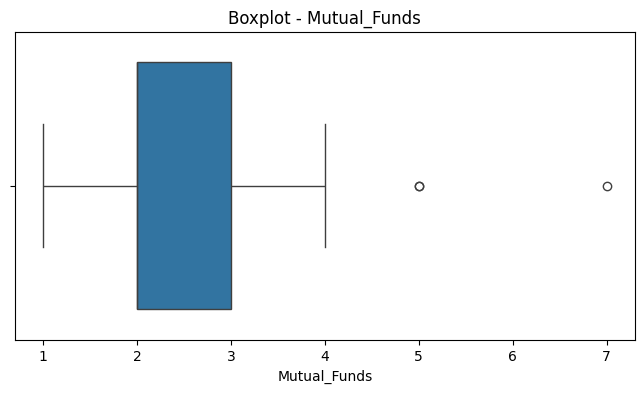

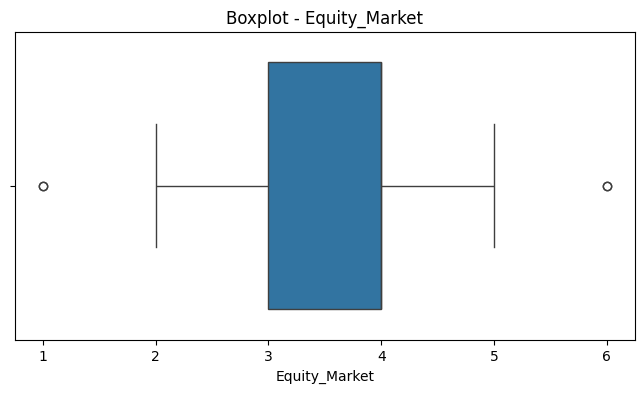

In [ ]:
for col in numeric_cols[:3]:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot - {col}')
    plt.show()

In [ ]:
#Estratégias de tratamento
df_treated = df.copy()

In [ ]:
#a)
for col in numeric_cols:
    Q1 = df_treated[col].quantile(0.25)
    Q3 = df_treated[col].quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    df_treated = df_treated[(df_treated[col] >= lower) & (df_treated[col] <= upper)]

In [ ]:
#b)
df_capped = df.copy()
for col in numeric_cols:
    Q1 = df_capped[col].quantile(0.25)
    Q3 = df_capped[col].quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    df_capped[col] = np.where(df_capped[col] < lower, lower,
                     np.where(df_capped[col] > upper, upper, df_capped[col]))


In [ ]:
#c)
df_log = df.copy()
for col in numeric_cols:
    if (df_log[col] > 0).all():
        df_log[col] = np.log(df_log[col])

In [ ]:
print('Estatísticas originais')
print(df[numeric_cols].describe().T)

print("\nApós remoção de outliers:")
print(df_treated[numeric_cols].describe().T)

print("\nApós Capping:")
print(df_capped[numeric_cols].describe().T)

print("\nApós Transformação Logarítmica:")
print(df_log[numeric_cols].describe().T)

Estatísticas originais
                  count    mean       std   min    25%   50%    75%   max
age                40.0  27.800  3.560467  21.0  25.75  27.0  30.00  35.0
Mutual_Funds       40.0   2.550  1.197219   1.0   2.00   2.0   3.00   7.0
Equity_Market      40.0   3.475  1.131994   1.0   3.00   4.0   4.00   6.0
Debentures         40.0   5.750  1.675617   1.0   5.00   6.5   7.00   7.0
Government_Bonds   40.0   4.650  1.369072   1.0   4.00   5.0   5.00   7.0
Fixed_Deposits     40.0   3.575  1.795828   1.0   2.75   3.5   5.00   7.0
PPF                40.0   2.025  1.609069   1.0   1.00   1.0   2.25   6.0
Gold               40.0   5.975  1.143263   2.0   6.00   6.0   7.00   7.0

Após remoção de outliers:
                  count       mean       std   min   25%   50%   75%   max
age                17.0  28.588235  3.163440  25.0  26.0  27.0  30.0  35.0
Mutual_Funds       17.0   2.235294  0.562296   1.0   2.0   2.0   3.0   3.0
Equity_Market      17.0   3.647059  0.606339   2.0   3.0   